In [1]:
import auction_data, os, analytics
hist_plot = auction_data.hist_plot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxpy
sns.set_style('white')
%matplotlib inline

In [2]:
tsuchiura_data = auction_data.AuctionData('tests/reference_data/tsuchiura_data.csv')

In [3]:
deviations = [-.02, -.0001, .0, .0005]
demands = [tsuchiura_data.get_counterfactual_demand(rho) for rho in deviations]
print(demands)

[0.6938393464942137, 0.25238257317903334, 0.25017018379850237, 0.24727705922396187]


In [4]:
constraints = [analytics.MarkupConstraint(max_markup=.5),
               analytics.InformationConstraint(k=.5, sample_demands=demands)]

In [5]:
installed_solvers = cvxpy.installed_solvers()
print(installed_solvers)
solvers = ['ECOS'] #, 'CVXOPT']
print(solvers)

['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'GLPK_MI', 'SCS', 'OSQP']
['ECOS']


seed_id 0 : seed=2345, project=True, num_points=10000.0
Using ECOS solver
minimum share of collusive histories: 0.24188595741622035

seed_id 1 : seed=2346, project=True, num_points=10000.0
Using ECOS solver
minimum share of collusive histories: 0.23310970530803685

seed_id 2 : seed=2347, project=True, num_points=10000.0
Using ECOS solver
minimum share of collusive histories: 0.23297309767501143

seed_id 3 : seed=2348, project=True, num_points=10000.0
Using ECOS solver
minimum share of collusive histories: 0.10841274627797963

seed_id 4 : seed=2349, project=True, num_points=10000.0
Using ECOS solver
minimum share of collusive histories: 0.03704124773006466

seed_id 5 : seed=2350, project=True, num_points=10000.0
Using ECOS solver
minimum share of collusive histories: -7.495408571735169e-11

seed_id 6 : seed=2351, project=True, num_points=10000.0
Using ECOS solver
minimum share of collusive histories: -1.1561052299917898e-10

seed_id 7 : seed=2352, project=True, num_points=10000.0
Using 

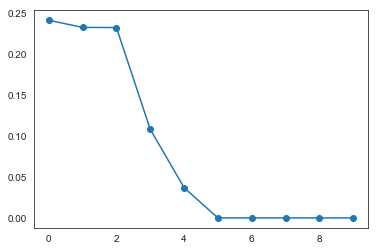

In [8]:
best_solutions = None
seeded_points = np.array([])
number_of_seeds = 10
first_seed = 2345
threshold = 0.005
min_share_of_collusive_hist = []

for solver in solvers:
    if solver not in installed_solvers:
        continue
    for project in [True]:
        seed_id = 0
        num_points = 1e6 * (1 - project) + 1e4 * project
        for seed in range(first_seed, first_seed + number_of_seeds):
          
            print('seed_id {} : seed={}, project={}, num_points={}'.format(seed_id, seed, project, num_points))

            try:
                min_collusion_solver = analytics.MinCollusionSolver(
                    data=tsuchiura_data,
                    deviations=deviations,
                    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
                    metric=analytics.IsNonCompetitive,
                    plausibility_constraints=constraints,
                    num_points=num_points,
                    seed=seed,
                    project=project,
                    solver_type=solver,
                    seeded_points=seeded_points
                    )

                print('minimum share of collusive histories: {}\n'.format(min_collusion_solver.solution))
                min_share_of_collusive_hist.append(min_collusion_solver.solution)
                
                sorted_solution = min_collusion_solver.argmin.sort_values("prob", ascending=False)
                #print(sorted_solution.head(10))
                
                if best_solutions is not None:
                    best_solutions = pd.concat([best_solutions,  sorted_solution.loc[sorted_solution.prob > threshold]])
                else:
                    best_solutions = sorted_solution.loc[sorted_solution.prob > threshold] 
                
                seeded_points = best_solutions.values[:,:-2]  
                seed_id += 1

            except Exception as e:
                print('Solver error: {}'.format(e))
                pass
    #print(best_solutions)
    plt.plot(range(0,number_of_seeds), min_share_of_collusive_hist, '-o')
    plt.show()
